<a href="https://colab.research.google.com/github/vishwas-yogi/Machine_learning_practice/blob/main/Hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pipeline**

In [1]:
import pandas as pd
df= pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header = None)
print(df.head())

         0  1      2      3       4   ...      27      28      29      30       31
0    842302  M  17.99  10.38  122.80  ...  0.6656  0.7119  0.2654  0.4601  0.11890
1    842517  M  20.57  17.77  132.90  ...  0.1866  0.2416  0.1860  0.2750  0.08902
2  84300903  M  19.69  21.25  130.00  ...  0.4245  0.4504  0.2430  0.3613  0.08758
3  84348301  M  11.42  20.38   77.58  ...  0.8663  0.6869  0.2575  0.6638  0.17300
4  84358402  M  20.29  14.34  135.10  ...  0.2050  0.4000  0.1625  0.2364  0.07678

[5 rows x 32 columns]


In [2]:
from sklearn.preprocessing import LabelEncoder
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y, random_state =1)
print(X_train.shape)

(455, 30)


In [4]:
#standarising the feature columns and compressing data from 30 dimensions to 2 using PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(random_state=1 , solver='lbfgs'))
principal_components = pipe_lr.fit(X_train, y_train)
# principal_df = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2'])
# print(principal_df.head())
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' %pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


K Fold cross-validation

In [5]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits = 10).split(X_train, y_train)
#kfold.split- Generate indices to split data into training and test set.
#kfold.get_n_splits- gives number of iterations 
scores = []
print(kfold)
#a generator is a function that returns an object (iterator) which we can iterate over (one value at a time).
for k , (train, test) in enumerate(kfold):
  pipe_lr.fit(X_train[train], y_train[train])
  score = pipe_lr.score(X_train[test], y_train[test])
  scores.append(score)
  print('Fold: %2d, Class dist:%s, Acc: %.3f' %(k+1, np.bincount(y_train[train]), score))

<generator object _BaseKFold.split at 0x7f7663bf5f50>
Fold:  1, Class dist:[256 153], Acc: 0.935
Fold:  2, Class dist:[256 153], Acc: 0.935
Fold:  3, Class dist:[256 153], Acc: 0.957
Fold:  4, Class dist:[256 153], Acc: 0.957
Fold:  5, Class dist:[256 153], Acc: 0.935
Fold:  6, Class dist:[257 153], Acc: 0.956
Fold:  7, Class dist:[257 153], Acc: 0.978
Fold:  8, Class dist:[257 153], Acc: 0.933
Fold:  9, Class dist:[257 153], Acc: 0.956
Fold: 10, Class dist:[257 153], Acc: 0.956


Direct stratified k fold cross validation scorer

In [6]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator = pipe_lr, X= X_train, y= y_train, cv= 10, n_jobs= 1)
print('CV accuracy scores: %s' %scores)

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


***Learning and Validation Curves***

Learning Curves

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty= 'l2', random_state= 1, solver= 'lbfgs', max_iter= 10000))
train_sizes, train_scores, test_scores = learning_curve(estimator= pipe_lr, X= X_train, y= y_train, train_sizes= np.linspace(0.1, 1.0, 10), cv= 10, n_jobs= 1)
print(train_sizes)
print(train_scores.shape) #array of shape (n_ticks, n_cv_folds) #single element - number of example(train_sizes) * number of iteration of cv
print(test_scores.shape)  #array of shape (n_ticks, n_cv_folds)
train_mean = np.mean(train_scores, axis= 1) #row wise- mean of train sizes after all the iterations
train_std= np.std(train_scores, axis= 1)
test_mean = np.mean(test_scores, axis= 1)
test_std = np.std(test_scores, axis= 1)

[ 40  81 122 163 204 245 286 327 368 409]
(10, 10)
(10, 10)


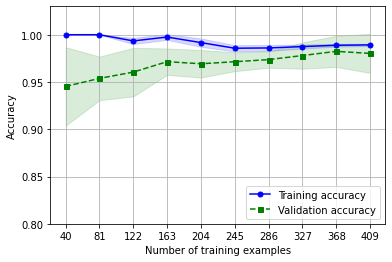

In [8]:
plt.plot(train_sizes, train_mean, color= 'blue', marker= 'o', markersize= 5, label= 'Training accuracy')
plt.fill_between(train_sizes, train_mean+ train_std, train_mean - train_std, alpha = 0.15, color = 'blue') #fill_between(x, y1, y2=0, where=None, interpolate=False, step=None, *, data=None, **kwargs)
plt.plot(train_sizes, test_mean, color= 'green', linestyle = "--" , marker= 's', markersize= 5, label= 'Validation accuracy')
plt.fill_between(train_sizes, test_mean+ test_std, test_mean - test_std, alpha = 0.15, color = 'green')
plt.grid()
plt.xlabel('Number of training examples')
plt.xticks(train_sizes)
plt.ylabel('Accuracy')
plt.legend(loc= 'lower right')
plt.ylim([0.8, 1.03])
plt.show()
#we can see from the curves that both our training and validation set work quite well if number of examples are greater than 250 in this case

Validation Curve

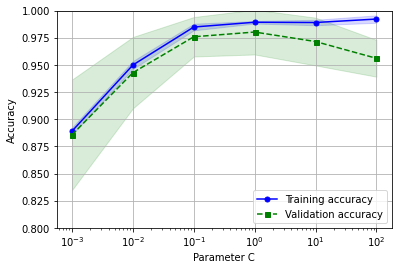

In [9]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator = pipe_lr, X= X_train, y= y_train, param_name = 'logisticregression__C', param_range= param_range, cv= 10)
train_mean = np.mean(train_scores, axis= 1)
train_std = np.std(train_scores, axis= 1)
test_mean = np.mean(test_scores, axis= 1)
test_std = np.std(test_scores, axis= 1)

plt.plot(param_range, train_mean, color= 'blue', marker= 'o', markersize= 5, label= 'Training accuracy')
plt.fill_between(param_range, train_mean+ train_std, train_mean - train_std, alpha = 0.15, color = 'blue') #fill_between(x, y1, y2=0, where=None, interpolate=False, step=None, *, data=None, **kwargs)
plt.plot(param_range, test_mean, color= 'green', linestyle = "--" , marker= 's', markersize= 5, label= 'Validation accuracy')
plt.fill_between(param_range, test_mean+ test_std, test_mean - test_std, alpha = 0.15, color = 'green')
plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.xticks(param_range)
plt.ylabel('Accuracy')
plt.legend(loc= 'lower right')
plt.ylim([0.8, 1.00])
plt.show()
#as we can observe from the following graph
#best c is between 0.01 and 0.1 

**Grid Search**

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state= 1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']}, {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
gs= GridSearchCV(estimator= pipe_svc, param_grid= param_grid, scoring= 'accuracy', cv= 10, refit= True, n_jobs= -1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

#verifying on independent test dataset
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test Accuracy: %.3f' %clf.score(X_test, y_test))

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Test Accuracy: 0.974


**Confusion** **Matrix**

In [11]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true= y_test, y_pred= y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


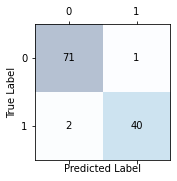

In [12]:
fig, ax = plt.subplots(figsize= (2.5, 2.5))
ax.matshow(confmat, cmap= plt.cm.Blues, alpha= 0.3)
for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x= j, y= i, s= confmat[i, j], va= 'center', ha= 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [13]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print('Precision: %.3f' %precision_score(y_true= y_test, y_pred= y_pred))
print('Recall: %.3f' %recall_score(y_true= y_test, y_pred= y_pred))
print('F1: %.3f' %f1_score(y_true= y_test, y_pred= y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [14]:
from sklearn.metrics import make_scorer, f1_score
c_gamma_range= [0.01, 0.1, 1.0, 10.0]
param_grid = [{'svc__C': c_gamma_range, 'svc__kernel': ['linear']}, {'svc__C': c_gamma_range, 'svc__gamma': c_gamma_range, 'svc__kernel': ['rbf']}]
scorer = make_scorer(f1_score, pos_label = 0)
gs = GridSearchCV(estimator= pipe_svc, param_grid= param_grid, scoring= scorer, cv= 10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


**Receiver Operating Characteristic**

3


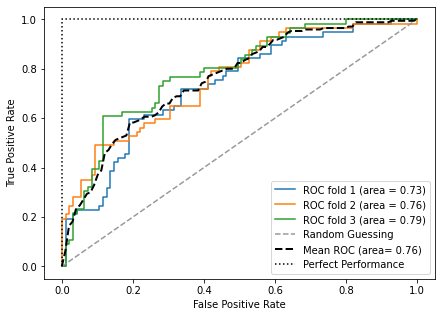

In [15]:
from sklearn.metrics import roc_curve, auc #auc- area under the curve
from numpy import interp

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components= 2), LogisticRegression(penalty= 'l2', random_state= 1, solver= 'lbfgs', C= 100.0))
X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits= 3).split(X_train, y_train))
print(len(cv))
fig = plt.figure(figsize= (7, 5))
mean_tpr= 0.0
mean_fpr= np.linspace(0, 1, 100)
all_tpr= []
for i, (train, test) in enumerate(cv):
  probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
  fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label= 1) #(true_class_labels, target_scores, positive_label)
  mean_tpr+= interp(mean_fpr, fpr, tpr) #(x co-cordinates at which we calcuate interpolated value, x co-ordinates of data points, y co-ordinates of data points)
  #interp returns interpolated values, shape same as x
  mean_tpr[0]= 0.0
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label= 'ROC fold %d (area = %0.2f)' %(i+1, roc_auc))

plt.plot([0, 1], [0, 1], linestyle= '--', color= (0.6, 0.6, 0.6), label= 'Random Guessing') #plotting line that connects (0, 0) and (1, 1)
mean_tpr /= len(cv)
mean_tpr[-1]= 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label = 'Mean ROC (area= %0.2f)' %mean_auc, lw= 2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle= ':', color= 'black', label= 'Perfect Performance') #plotting line that connects (0, 0), (0, 1) and (1, 1)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Multiclass Scoring Metrics

In [16]:
pre_scorer = make_scorer(score_func= precision_score, pos_label =1, greater_is_better= True, average = 'micro')
gs = GridSearchCV(estimator= pipe_svc, param_grid= param_grid, scoring= pre_scorer, cv= 10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9824154589371981
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
